In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.


(32 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
64 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
Dense 256 -> 
PReLU -> 
Dense 256 -> 
PReLU -> 
Dense 2) 

For different datasets we use a network with different number of input channels eg. MNIST or SVHN

<img src="./images/siamese.png" height="422" width="722" >

Contrastive loss function is given by the following :-

$$\mathcal{L}(I_{1}, I_{2}) = y[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]^{2} + (1-y)*ReLU([\mathcal{m}-[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]]^{2})$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import SiameseCD,SiameseMNIST,SiameseSVHN

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Contrastive  Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        
        primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        #plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        
        helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        
        #plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 8))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [8]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.184695
Train: [12800/50000 (26%)]	Loss: 0.129586
Train: [25600/50000 (51%)]	Loss: 0.125961
Train: [38400/50000 (77%)]	Loss: 0.125449
Epoch: 1/20. Train set: Average loss: 0.1268
Epoch: 1/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.124819
Train: [12800/50000 (26%)]	Loss: 0.125410
Train: [25600/50000 (51%)]	Loss: 0.125348
Train: [38400/50000 (77%)]	Loss: 0.125321
Epoch: 2/20. Train set: Average loss: 0.1253
Epoch: 2/20. Validation set: Average loss: 0.1251
Train: [0/50000 (0%)]	Loss: 0.124741
Train: [12800/50000 (26%)]	Loss: 0.125272
Train: [25600/50000 (51%)]	Loss: 0.125343
Train: [38400/50000 (77%)]	Loss: 0.125330
Epoch: 3/20. Train set: Average loss: 0.1253
Epoch: 3/20. Validation set: Average loss: 0.1212
Train: [0/50000 (0%)]	Loss: 0.124326
Train: [12800/50000 (26%)]	Loss: 0.113254
Train: [25600/50000 (51%)]	Loss: 0.087637
Train: [38400/50000 (77%)]	Loss: 0.072147
Epoch: 4/20. Train set: Average loss: 0.0840
Epoch: 4/20. Valid

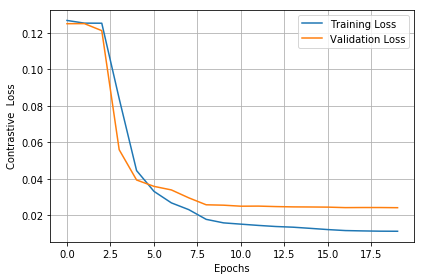

In [9]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.039s...
[t-SNE] Computed neighbors for 5000 samples in 5.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.007170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.971092
[t-SNE] Error after 300 iterations: 2.071682


NameError: global name 'helper_inds' is not defined

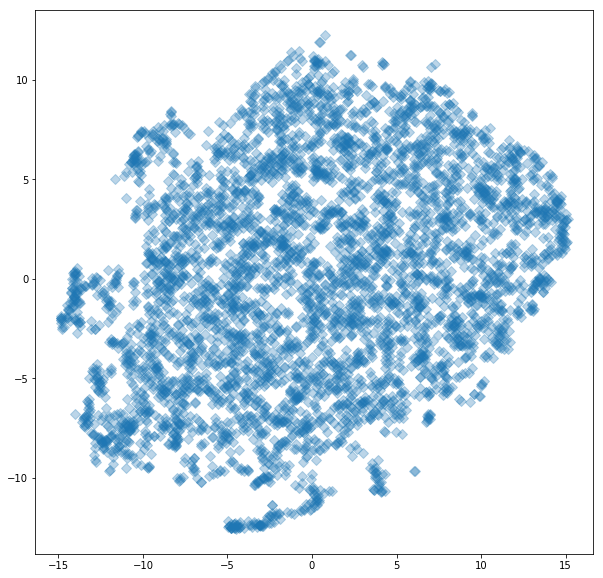

In [14]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.001s...
[t-SNE] Computed neighbors for 980 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.005225
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.437931
[t-SNE] Error after 300 iterations: 1.192291
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1744 samples in 0.001s...
[t-SNE] Computed neighbors for 1744 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1744
[t-SNE] Computed conditional probabilities for sample 1744 / 1744
[t-SNE] Mean sigma: 0.014455
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.623642
[t-SNE] Error after 300 iterations: 1.514573
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.001s...
[t-SNE] Computed neighbors for 1135 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Co

[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.846348
[t-SNE] Error after 300 iterations: 1.279465
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1595 samples in 0.001s...
[t-SNE] Computed neighbors for 1595 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1595
[t-SNE] Computed conditional probabilities for sample 1595 / 1595
[t-SNE] Mean sigma: 0.018237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.191116
[t-SNE] Error after 300 iterations: 1.423758


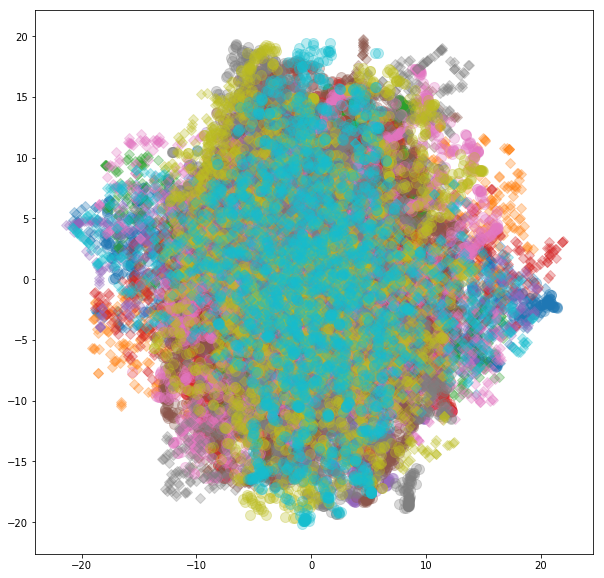

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [25]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)


siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [26]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.264247
Train: [12800/50000 (26%)]	Loss: 0.131794
Train: [25600/50000 (51%)]	Loss: 0.125897
Train: [38400/50000 (77%)]	Loss: 0.125886
Epoch: 1/20. Train set: Average loss: 0.1278
Epoch: 1/20. Validation set: Average loss: 0.1289
Train: [0/50000 (0%)]	Loss: 0.136484
Train: [12800/50000 (26%)]	Loss: 0.125623
Train: [25600/50000 (51%)]	Loss: 0.125274
Train: [38400/50000 (77%)]	Loss: 0.125192
Epoch: 2/20. Train set: Average loss: 0.1200
Epoch: 2/20. Validation set: Average loss: 0.0858
Train: [0/50000 (0%)]	Loss: 0.094068
Train: [12800/50000 (26%)]	Loss: 0.058437
Train: [25600/50000 (51%)]	Loss: 0.038897
Train: [38400/50000 (77%)]	Loss: 0.034280
Epoch: 3/20. Train set: Average loss: 0.0403
Epoch: 3/20. Validation set: Average loss: 0.0295
Train: [0/50000 (0%)]	Loss: 0.028905
Train: [12800/50000 (26%)]	Loss: 0.023798
Train: [25600/50000 (51%)]	Loss: 0.019404
Train: [38400/50000 (77%)]	Loss: 0.018134
Epoch: 4/20. Train set: Average loss: 0.0194
Epoch: 4/20. Valid

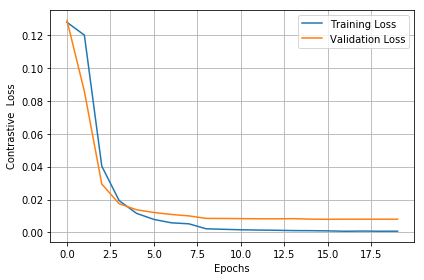

In [27]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

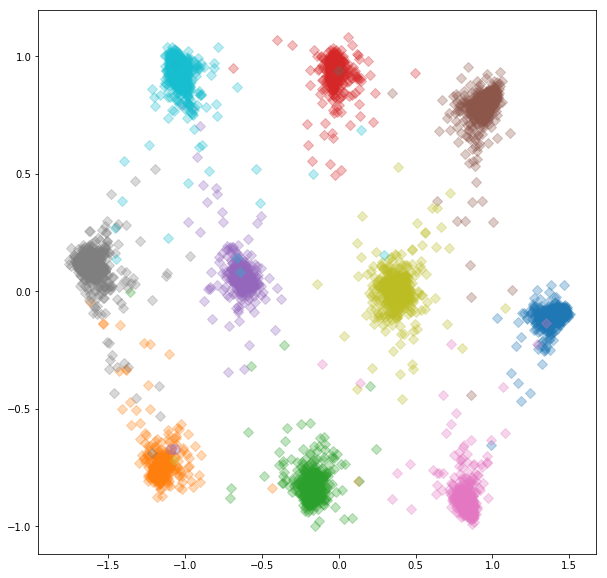

In [28]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

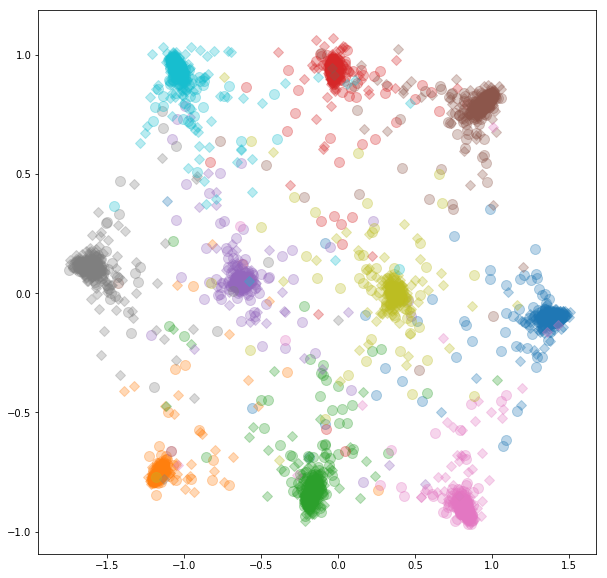

In [29]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Online Pair Selection 

 We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)